# 17 Importance Sampling

The Monte Carlo integration procedure with uniform sampling 

$$
I = \int_{a_1}^{b_1} \cdots \int_{a_M}^{b_M} f(x_1, \dots, x_M) dx_1\cdots dx_M \approx V \langle f \rangle_\text{mc}
$$

works well with monotonic and smooth integrands $f$. However, 

* sharply peaked
* oscillating

integrands are problematic (like for any integration method).

Oscillations increase fluctuations in random sampling and require more sampling.

Sharp peaks are especially annoying for *uniform sampling* because most of the samples will come from regions outside the peak and not contribute to the integral.

## Importance sampling method

**Importance sampling** is a method to turn a non-smooth $f(x)$ into a smoother $g(x)$ by separating the integrand

$$
\int_a^b \! f(x) dx = \int_a^b \! \frac{f(x)}{P(x)} P(x) dx = \int_a^b \! g(x) P(x) dx, \quad g(x) := \frac{f(x)}{P(x)}
$$

The new function $g(x)$ is supposed to be smoother than $f(x)$. 

$P(x)$ is a known probability distribution and we are again calculating a *weighted average*, this time over our new function $g(x)$. The trick will be to generate samples according to $P(x)$ and then calculate the average $\langle g \rangle_\text{mc}$:

$$
\int_a^b \! f(x) dx = \langle g \rangle_\text{mc} = \frac{1}{N} \sum_{i=1}^N g(x_i) = \frac{1}{N} \sum_{i=1}^N \frac{f(x_i)}{P(x_i)}
$$

* The average $\langle g \rangle_\text{mc}$ *must* be calculated for samples $x \sim P$.
* The probability distribution $P(x)$ should be chosen so that the modified integrand $g(x) = f(x)/P(x)$ should become as smooth as possible (ideally, close to uniform).
* The integration volume does not explicitly appear in the importance sampling equation. It is taken into account implicitly by the sampling process.
* Importance sampling with the uniform distribution $P(x) = (b-a)^{-1}$ reduces to the *weighted average method*.
* Importance sampling generalizes to $M$ dimensions just as standard MC sampling.

## Example

The integral
$$
\int_a^b \! f(x) dx = \int_0^\infty \! \cos x \, e^{-x} dx = \frac{1}{2}
$$
oscillates and is strongly peaked at the origin.

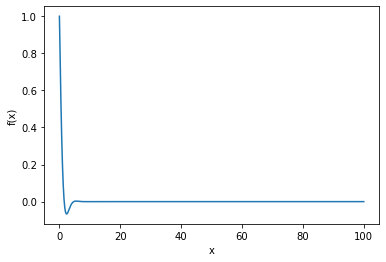

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.cos(x) * np.exp(-x)

X = np.linspace(0, 100, 400)
plt.plot(X, f(X))
plt.xlabel("x"); plt.ylabel("f(x)");

Oscillations are not so problematic but if we want to integrate "to infinity" then we really should take care of the peak at the origin.

Choose the exponential distribution
$$
P(x) = e^{-x}
$$
which is already normalized on the interval $[0, +\infty[$.

We then get
$$
g(x) = \frac{f(x)}{P(x)} = \cos x.
$$



In [13]:
def g(x):
    return np.cos(x)

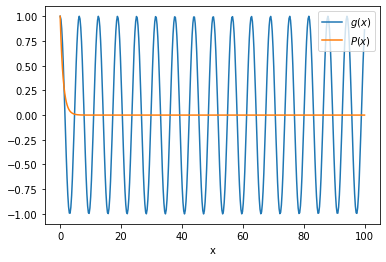

In [17]:
plt.plot(X, g(X), X, np.exp(-X))
plt.legend((r"$g(x)$", r"$P(x)$"))
plt.xlabel("x");

Note that the exponential distribution stretches to infinity. However, it is very unlikely to draw samples for large $x$ values.

But how do we sample from the exponential distribution?

1. Look through the docs for the [distributions](https://numpy.org/doc/stable/reference/random/generator.html#distributions) that [numpy's Random Generator](https://numpy.org/doc/stable/reference/random/generator.html) can provide, namely the [exponential distribution](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.exponential.html#numpy.random.Generator.exponential).
2. Transform samples from the *uniform* distribution to the exponential distribution.

### Exponential distribution with `numpy.random.Generator.exponential`

If we have well-tested, documented, and high performance code then we should know how to use it:

In [9]:
import numpy as np
rng = np.random.default_rng()

In [38]:
N = 1000
x = rng.exponential(scale=1.0, size=N)
fMC = np.mean(g(x))

fanalytical = 1/2
error = 1 - fMC/fanalytical

print(f"fMC = {fMC} ({N} samples)")
print(f"f = {fanalytical} (error = {error})")

fMC = 0.48969567139965026 (1000 samples)
f = 0.5 (error = 0.020608657200699487)


The error decreases with increasing sample size (as can be seen by modifying `N`).

Note that the samples are overwhelmingly appearing in the region where the function $f(x)$ was peaked, i.e., near the origin, and so $g(x)$ is only evaluated near the origin. Hence only those *important* data points contribute to the average. To obtain samples farther out ($x>10$) requires many samples to be drawn. The integration boundaries are implicitly taken into account via the sampling from the exponential distribution: in principle, a sample for very large $x$ *could* be drawn even though it is overwhelmingly unlikely.

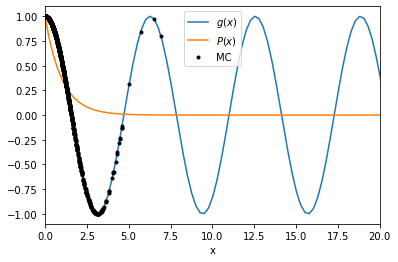

In [39]:
plt.plot(X, g(X), X, np.exp(-X))
plt.plot(x, g(x), 'k.')
plt.legend((r"$g(x)$", r"$P(x)$", "MC"))
plt.xlim(0, 20)
plt.xlabel("x");

### Exponential distribution with inverse transform
(follows *Computational Methods* Ch 10.B)

We often have to draw samples from a nonuniform distribution. The general approach is to draw samples from the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution) $\mathcal{U}_\text{[a, b]}$ over the interval $[a, b]$:

\begin{align}
x &\sim \mathcal{U}_\text{[a, b]}\\
p_x(x) &= \begin{cases}
   \frac{1}{b -a }, \quad a \le x \le b\\
   0, \text{otherwise}
   \end{cases}
\end{align}   

and then transform the random samples $x$ to the desired samples $y \sim p_y$ that are non-uniformly distributed according to $p_y(y)$.

In the best case, we can obtain the nonuniform distribution *analytically* by using the *inverse transform method*. Let's assume that the transformation
$$
y = G(x)
$$
exists, which transforms a sample $x \sim p_x$ into $y \sim p_y$.

The derivation starts from the *conservation of probability*
$$
|p_y(y) dy| = |p_x(x) dx|
$$

The probability in $[y, y+dy]$ must equal the probability in the corresponding interval $[x, x+dx]$ because $G: x \mapsto y=G(x)$ in a one-to-one fashion.

Let's sample from the uniform distribution $\mathcal{U}_\text{[0, 1]}$ so $p_x(x) = 1$.

Integrate the conservation of probability equation (and pulling the absolute magnitude out of the integral because $\sum_i |a_i| = \left|\sum_i a_i\right|$ if $a_i \ge 0\ \forall i$):

\begin{gather}
\left|\int p_y(y) dy\right| = \int 1 dx = x\\
F(y) := \left|\int p_y(y) dy\right| = x\\
F(y) = x
\end{gather}

If we can solve the integral $\int p_y(y) dy$ analytically and if the inverse of $F(x)$ exists,
$$
y = F^{-1}(x) = G(x)
$$
then we have the **inverse transform**.

Apply to the *exponential distribution*:
\begin{gather}
p_y(y) = e^{-y}\\
F(y) = \left|\int p_y(y) dy\right| = \left|-e^{-y}\right| = e^{-y}\\
F(y) = x\\
e^{-y} = x\\
\end{gather}

to yield the inverse transform

$$
y = -\ln(x), \quad 0 \le x \le 1, \ 0 \le y \le + \infty
$$

The logarithm is the inverse transform of the exponential.

Thus the logarithm of a uniform sample in $[0, 1]$ yields a sample that is exponentially distributed. It "squishes" the samples near $x=1$ towards $y=0$ and expands the samples near $y=0$ towards infinity.



Our MC importance sampling now just has one extra step: transform the uniform samples:

In [40]:
N = 1000
x = rng.uniform(low=0, high=1, size=N)
y = -np.log(x)
fMC = np.mean(g(y))

fanalytical = 1/2
error = 1 - fMC/fanalytical

print(f"fMC = {fMC} ({N} samples)")
print(f"f = {fanalytical} (error = {error})")

fMC = 0.49704661874486056 (1000 samples)
f = 0.5 (error = 0.0059067625102788845)


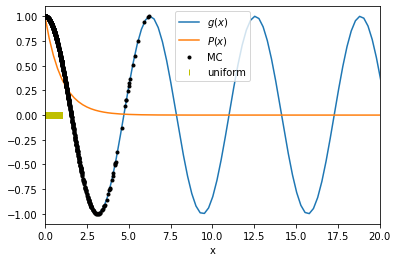

In [42]:
plt.plot(X, g(X), X, np.exp(-X))
plt.plot(y, g(y), 'k.')
plt.plot(x, np.zeros_like(x), 'y|')
plt.legend((r"$g(x)$", r"$P(x)$", "MC", "uniform"))
plt.xlim(0, 20)
plt.xlabel("x");